In [1]:
##################################################################################################
# PURPOSE:
#   Calculate photometric magnitudes for passbands. 
# CALLING SEQUENCE:
#    python calmag.py
# INPUTS:
#    galaxy_list.csv
# PARAMETERS:
#    
# OUTPUT:
#    Magnitude of each galaxy from galaxy_list.csv
# REQUIRED SCRIPTS & DATA:
#   "softening"
#   "vega.out"
#   "vega.out"
#   "Filters_sdss/"
##################################################################################################
import numpy as np
import pandas as pd
from os import path
import time
from astropy.io import fits as pf
from astropy.table import Table

list = dir() #Seriam estas duas linhas o equivalente?
del list

#################################
# DEFINITIONS
#################################
sdss_band = "r"  # g, r, i, z # r have the best response between the SDSS bands

spectra_z_file = '../aux_files/galaxy_list.csv'
sample = pd.read_csv(spectra_z_file, sep=',')
data = pd.read_csv(spectra_z_file, sep=',')
selection = (data['onoff'] == 1) #Selecting only Gemini galaxies
data = data[selection]
data.index = range(len(data))

#################################
# FUNCTIONS
#################################
# --------------------------
# Function for interpolation
# --------------------------
def interp(xin,xout,yin):
    Ninterpol = len(xout)
    yout = np.array([])
    
    for k in range(Ninterpol): 
        t = xin[xin < xout[k]]
        tind = len(t) -2 #VERIFICAR SE ESTE -2 NÃO INTERFERE NOS RESULTADOS
        
        if tind <= 0: tind = 1
        if tind >= len(xin): tind = len(xin) - 1
        t1 = xin[tind - 1]
        t2 = xin[tind]
        t3 = xin[tind + 1]
        tx = xout[k]

        A = (tx - t1) / (t3 - t1)
        B = (tx - t2) / (t3 - t2)
        C = (tx - t3) / (t2 - t1)
        D = (tx - t1) / (t3 - t2)
        E = (tx - t2) / (t3 - t1)

        G = (tx - t2) / (t3 - t2)
        H = (tx - t1) / (t2 - t1)
        
        if (t1 != t2) & (t2 != t3):
            yout = np.append(yout, yin[tind+1] * A * B - yin[tind] * D * C + yin[tind-1] * E * C)
                
        if (t1 == t2):
            yout = np.append(yout, yin[tind+1] - yin[tind]) * G + yin[tind] 
        
        if(t2 == t3):
            yout = np.append(yout, yin[tind] - yin[tind-1]) * H + yin[tind-1] 
        
    return(yout)

# ------------------------------------
# Function for computing the magnitude
# ------------------------------------
def getmag(Flux, band, fvega):
    vega_abmag = pd.DataFrame([-0.08, 0.17, 0.40, 0.57]) #References? I founded another table of values
    #vega_abmag = pd.DataFrame([-0.08, 0.16, 0.37, 0.54])
    f0 = fvega
    t = pd.read_csv("softening", delim_whitespace=True)
    t.columns = ("V1","V2","V3","V4","V5")
    
    b = t.V2[t.V1 == band] # "Softening parameter: typical 1-sigma noise of the sky in a PSF aperture in 1" seeing"
    f0b = f0[bands == band] # Vega Flux
    
    mag = (-2.5 / np.log(10)) * (np.arcsinh((Flux/f0b) / (2*b)) + np.log(b)) + float(vega_abmag[bands == band][0])
    #The equation above can be accessed in https://www.sdss.org/dr12/algorithms/magnitudes/
    #The use of arcsinh is an usefull techinque to report a magnitude even in the absence of a formal detection, since negative flux fails in the log way
    
    return(mag)


#################################
# READ FILTER
#################################
t = pd.read_csv("Filters_sdss/"+ sdss_band + ".dat", index_col=False, delim_whitespace=True, skiprows=6, header=None)
t.columns = ("V1","V2","V3","V4","V5")
filter_l = np.array(t.V1) #Lambda filter
filter_curve = np.array(t.V4) #Filter response in sdss_band band (a coefficient)
filter_lmin = filter_l[0] #Minimum lambda with response > 0 in the filter
filter_lmax = filter_l[len(filter_l)-1] #Maximum lambda with response > 0 in the filter

dl = 0.1 #step
filter_lout = np.linspace(filter_lmin, filter_lmax, num = int((filter_lmax-filter_lmin)/dl+1))
filter_lout = np.round(filter_lout, 1)
#By increasing the number of lambda intervals, we decrase the error in the "integration" (in fact, is just a sum of all these small regions).
#The higher the value of filter_lout, more precise the integration will be

filter_curveout = interp(filter_l, filter_lout, filter_curve) #Output of the interpolation of filter_curve of filter_l to filet_lout

#################################
# READ VEGA
#################################
t = pd.read_csv("vega.out", skiprows=4, delim_whitespace=True, index_col=False, header=None)
t.columns = ("V1","V2","V3")

lvega = np.array(t.V2) #Lambda of Vega
fvega = np.array(t.V3) #Flux of Vega
fvegaout = interp(lvega, filter_lout, fvega) #Interpolated flux of Vega in filter_lout lambda interval

#nu1 = 2.99792e8 / ((4702.5 - 928.17/2) * 1e-10)
#nu2 = 2.99792e8 / ((4702.5 + 928.17/2) * 1e-10)
#dnu = abs(nu1 - nu2)

flux_vega = sum(fvegaout * filter_curveout) * dl #Final flux vega

bands = np.array(["g","r","i","z"])
filter_vega = np.array([-99.0,-99.0,-99.0,-99.0]) #Just storage
filter_vega[bands == sdss_band] = flux_vega

mag_vega = getmag(flux_vega, sdss_band, filter_vega) #Magnitude of vega

#####################################################
for i in range(len(data)):
    if data.flag_sdss[i] == 0:
        input_spec = "../files_gemini/csv_" + str(data.lcgID[i]) + "/csv_LCG" + str(data.lcgID[i]) + "_" + str(data.extension[i]) + ".csv"
        t = pd.read_csv(input_spec, delim_whitespace=True, header=None)
    if data.flag_sdss[i] == 1:
        hdul_sdss = pf.open('../files_sdss/' + str(data.lcgID[i]) + '_' + str(data.extension[i]) + '.fits', memmap=True)
        evt_sdss = Table(hdul_sdss[1].data)
        try:
            sdss = pd.DataFrame([10**evt_sdss['loglam'], evt_sdss['flux'], 1/np.sqrt(evt_sdss['ivar'])]).T
        except:
            sdss = pd.DataFrame([10**evt_sdss['LOGLAM'], evt_sdss['FLUX'], 1/np.sqrt(evt_sdss['IVAR'])]).T
        sdss.columns = ['lambda', 'flux', 'error']
        sdss['flux'] = sdss['flux'] / 1e17
        t = sdss[['lambda', 'flux']]

    t.columns = ("V1","V2")
    filter_obsout = interp(t.V1, filter_lout, t.V2) #Final flux of the target in filter_lout lambda interval
    mag_filter = getmag(sum(filter_obsout * filter_curveout) * dl, sdss_band, filter_vega) #Final magnitude of the target in the sdss_band band
    
#################################
# SAVING RESULTS INTO galaxy_list.csv (main file)
#################################

    data.magSlit_r[i] = round(mag_filter,5)
    print("LCG" + str(data.lcgID[i]) + "_" + str(data.extension[i]) + ": " + "magnitude in the " + sdss_band + " band: " + str(float(mag_filter)))
    
for k in range(len(data)):
    for j in range(len(sample)):
        if (sample.ra[j] == data.ra[k]) & (sample.extension[j] == data.extension[k]):
            sample.magSlit_r[j] = data.magSlit_r[k]
            
sample.to_csv('../aux_files/galaxy_list.csv', index=False)

LCG1864_1: magnitude in the r band: 18.950151690293744


<ipython-input-1-cd76ff669927>:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.magSlit_r[i] = round(mag_filter,5)


LCG1864_3: magnitude in the r band: 18.731211408808917
LCG1864_2: magnitude in the r band: 19.163442679785792
LCG2023_3: magnitude in the r band: 18.15376808113681


<ipython-input-1-cd76ff669927>:150: RuntimeWarning: divide by zero encountered in true_divide
  sdss = pd.DataFrame([10**evt_sdss['loglam'], evt_sdss['flux'], 1/np.sqrt(evt_sdss['ivar'])]).T


LCG2023_2: magnitude in the r band: 18.27986683843613
LCG2023_1: magnitude in the r band: 18.271710939060974
LCG2247_15: magnitude in the r band: 18.1616510110431
LCG2247_5: magnitude in the r band: 18.03322218066684
LCG2247_518: magnitude in the r band: 18.167884476628515
LCG2247_7: magnitude in the r band: 19.453773274697124
LCG2247_2: magnitude in the r band: 21.146122403809397
LCG2361_13: magnitude in the r band: 18.45129099561097
LCG2361_4: magnitude in the r band: 18.990053452114626
LCG2361_2: magnitude in the r band: 19.717391435524018
LCG2361_5: magnitude in the r band: 18.910412374771113
LCG2361_3: magnitude in the r band: 17.969843558999028
LCG2361_318: magnitude in the r band: 18.06968187077082


<ipython-input-1-cd76ff669927>:152: RuntimeWarning: divide by zero encountered in true_divide
  sdss = pd.DataFrame([10**evt_sdss['LOGLAM'], evt_sdss['FLUX'], 1/np.sqrt(evt_sdss['IVAR'])]).T


LCG2764_2: magnitude in the r band: 18.06918367463473
LCG2764_3: magnitude in the r band: 17.058935532939504
LCG2764_1: magnitude in the r band: 16.685184087676543
LCG3090_3: magnitude in the r band: 18.41351759169457
LCG3090_2: magnitude in the r band: 19.189554999825265
LCG3090_1: magnitude in the r band: 18.27116288362264
LCG3174_15: magnitude in the r band: 18.350805429309034
LCG3174_14: magnitude in the r band: 18.08598753789136
LCG3174_3: magnitude in the r band: 18.09094313060622
LCG3174_4: magnitude in the r band: 18.132569173424407
LCG3174_5: magnitude in the r band: 18.55123950089656
LCG3174_518: magnitude in the r band: 18.7326220134299
LCG3174_2: magnitude in the r band: 20.499499566519603
LCG3866_13: magnitude in the r band: 17.615622705283855
LCG3866_15: magnitude in the r band: 18.583041692327964
LCG3866_17: magnitude in the r band: 18.265934450627572
LCG3866_5: magnitude in the r band: 18.238426746509802
LCG3866_7: magnitude in the r band: 17.600353354151302
LCG3866_6: 

<ipython-input-1-cd76ff669927>:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.magSlit_r[j] = data.magSlit_r[k]


In [48]:
/########################### IMPORTANTE ################################
# Substitui os valores das magnitudes das galáxias que descobrimos fazer parte dos grupos utilizando o gemini
########################################################################

spectra_z_file = '../aux_files/galaxy_list.csv'
sample = pd.read_csv(spectra_z_file, sep=',')
sample = sample[['lcgID',"extension","ra","dec","z","magPetro_r","magSlit_r","fiberMag_r",'petroR90_r_lcg','logMstar_lcg_sdss','flag_lcg','flag_sdss','onoff']]
sample.magPetro_r[17] =  19.55 #Obtido no SDSS
sample.magPetro_r[38] =  19.85 #Obtido no SDSS
sample.magPetro_r[46] =  19.66 #Obtido no SDSS
sample.magPetro_r[85] =  19.86 #Obtido no SDSS
sample.to_csv(spectra_z_file, sep=',', index=None)

<ipython-input-48-dfe8a11d3d00>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.magPetro_r[17] =  19.55 #Obtido no SDSS
<ipython-input-48-dfe8a11d3d00>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.magPetro_r[38] =  19.85 #Obtido no SDSS
<ipython-input-48-dfe8a11d3d00>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.magPetro_r[46] =  19.66 #Obtido no SDSS
<ipython-input-48-dfe8a11d3d00>:11: SettingWithCopyWar

0.9999999999999998 0.0


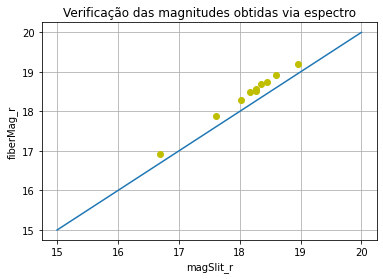

In [114]:
########################################################################
#                         PLOT IMPORTANTE
########################################################################

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
data = pd.read_csv('../aux_files/TESTE_MAG.csv')
selecao = (data['flag_lcg'] == 1) & (data['flag_sdss'] == 1) & (data['onoff'] == 1)
data = data[selecao]

pp = PdfPages('mag_verification.pdf')
plt.plot('magSlit_r', 'fiberMag_r', 'yo', data=data)

plt.plot([15,20],[15,20])

plt.xlabel('magSlit_r')
plt.ylabel('fiberMag_r')
plt.grid()
plt.title('Verificação das magnitudes obtidas via espectro')
#plt.savefig(pp, format='pdf', figsize=(3,3))

#coefang = mlines.Line2D([], [], color='black',
#                          markersize=15, label='Coef. ang. = 1.028')
#coeflin = mlines.Line2D([], [], color='black',
#                          markersize=15, label='Coef. lin. = -0.223')
#plt.legend(handles=[coefang, coeflin])

plt.savefig(pp, format='pdf', figsize=(3,3))


pp.close()
